**Dataset**: https://www.nature.com/articles/s41597-024-03237-9

**Encoder and Decoder Reference**: https://www.youtube.com/watch?v=U0s0f995w14

**user ID** is the unique identifier of the mobile phone user (type: integer)

**day** is the masked date of the observation. It may take a value between 0 and 74 for both Dataset 1 and Dataset 2 (type: integer).

The location pings are discretized into 500 meters × 500 meters grid cells and the timestamps are rounded up into 30-minute bins. The actual date of the observations is not available either (i.e., timeslot t of day d) to protect privacy. In the second Dataset, the 75 day period is composed of 60 days of business-as-usual and 15 days during an emergency with unusual behavior.

**timeslot** is the timestamp of the observation discretized into 30 minute intervals. 
It may take a value between 0 and 47, where 0 indicates between 0AM and 0:30AM, 
and 13 would indicate the timeslot between 6:30AM and 7:00AM.

**x,y** are the coordinates of the observed location mapped onto the 500 meter discretized grid cell. It may take a value between (1, 1) and (200, 200). Details are shown in Fig. 2.

# Import Libraries

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import random

# Load Data

In [2]:
# yjmob1 = 'yjmob100k-dataset1.csv.gz'
# yjmob2 = 'yjmob100k-dataset2.csv.gz'
# yjmob_df = pd.concat([pd.read_csv(yjmob1, compression='gzip'),
#                       pd.read_csv(yjmob2, compression='gzip')]).sort_values(
#                                                                       by=['uid'],
#                                                                    ignore_index=True)

In [3]:
yjmob1 = 'yjmob100k-dataset1.csv.gz' # dataset under normal scenes
yjmob_df = pd.read_csv(yjmob1, compression='gzip')

In [59]:
# Retrieve all ids

uids = yjmob_df['uid'].unique()

In [60]:
# Just to reduce memory space
rand_indicies = [random.randint(0, len(uids)) for _ in range(10000)]
selected_uids = [uid for uid in uids[rand_indicies]]

In [61]:
df = yjmob_df[yjmob_df['uid'].isin(selected_uids)] 

# Tokenization

In [62]:
# linearization of the 2-dimensional grid, i.e., the original x,y coordinate system
def spatial_token(x, y):
    # x,y are the coordinate location
    # x determines the column order while
    # y determines the row order
    # (x-1) calculates the starting grid-column position
    # (y-1)*200 calculates the start index of the grid-row
    return (x-1)+(y-1)*200

In [63]:
# Location

df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)

/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_22343/458494843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_xy'] = df.apply(lambda row: spatial_token(row['x'], row['y']), axis=1)


# Train-Test Split

In [64]:
# 8:2 split

train_uids, test_uids = train_test_split(selected_uids, test_size=0.2, random_state=42)

df_train = df[df['uid'].isin(train_uids)]
df_test = df[df['uid'].isin(test_uids)]

## Batching

In [65]:
BATCH_SIZE = 25

In [66]:
# Group data by uid

# grouped_data_train = df_train[['uid', 't', 'combined_xy']].groupby('uid')
grouped_data_train = [group for _, group in df_train.groupby('uid')]

# grouped_data_test = df_test[['uid', 't', 'combined_xy']].groupby('uid')
grouped_data_test = [group for _, group in df_test.groupby('uid')]

In [25]:
STEP_SIZE = 100

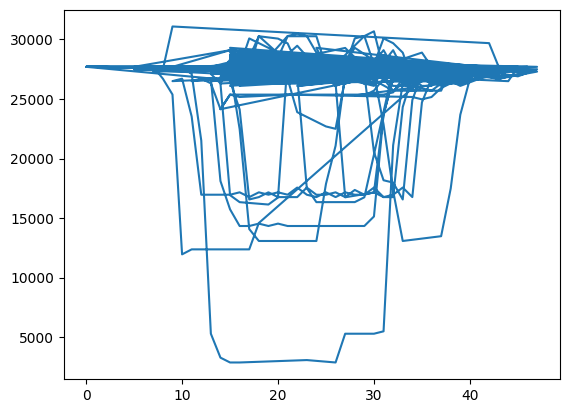

In [70]:
plt.plot(grouped_data_train[2]['t'],grouped_data_train[2]['combined_xy'])

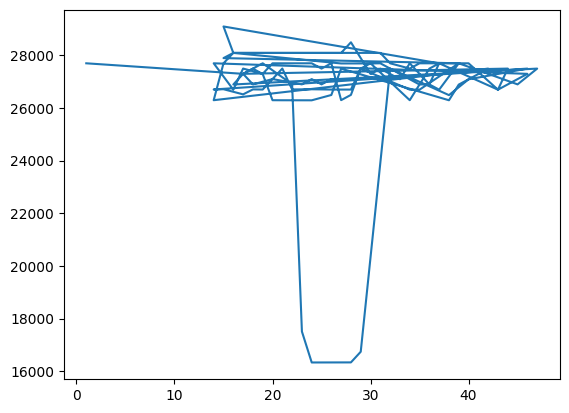

In [71]:
plt.plot(grouped_data_train[2]['t'][:100],grouped_data_train[2]['combined_xy'][:100])

In [72]:
# Output input location sequence (trajectory), desired output location
# along with the time when that user reaches a location

def generate_sequences(data, data_t):
    return torch.tensor(data[:STEP_SIZE]),torch.tensor(data[STEP_SIZE]),\
                torch.tensor(data_t[:STEP_SIZE]),torch.tensor(data_t[STEP_SIZE])

In [73]:
class TrajectoryDataset(Dataset):
    def __init__(self, grouped_data):
        self.data = grouped_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_for_uid = self.data[idx]
        inputs, labels, positions, label_positions = generate_sequences(
                                                         data_for_uid['combined_xy'].values.tolist(),
                                                         data_for_uid['t'].values.tolist())
        return inputs, labels, positions, label_positions

train_dataset = TrajectoryDataset(grouped_data_train) # train_dataset.__getitem__(0)
test_dataset = TrajectoryDataset(grouped_data_test)

In [74]:
def collate_fn(batch):
    # Unzip all batch
    inputs_batch, labels_batch, positions_batch, label_positions_batch = zip(*batch)
    
    # Pad the sequence with less length in a batch
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs_batch, padding_value=0.0, batch_first=True)
    labels_padded = torch.tensor(np.array(labels_batch))
    positions_padded = torch.nn.utils.rnn.pad_sequence(positions_batch, padding_value=0, batch_first=True)
    label_positions_padded = torch.tensor(np.array(label_positions_batch))
    
    return inputs_padded, labels_padded, positions_padded, label_positions_padded

In [75]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [76]:
# # Example
# data_iter = iter(train_dataloader)
# inputs, labels, positions, label_positions = next(data_iter)
# print("Shape of inputs:", inputs.shape) # Shape: [batch_size, seq_len]
# print("Shape of labels:", labels.shape) # Shape: [batch_size]
# print("Shape of positions:", positions.shape) # Shape: [batch_size, seq_len]
# print("Shape of positions:", label_positions.shape) # Shape: [batch_size]

# Transformer

## Input Embedding and Positional Encoding

https://pytorch.org/tutorials/beginner/transformer_tutorial.html#load-and-batch-data

In [78]:
# Time - Positional Encoding = Time Embedding + Sequential Encoding
# max_len is the maximum expected data length

class PositionalEncoding(nn.Module):
    def __init__(self, max_len, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-np.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 0, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return x # self.dropout(x)

## Self-Attention

In [79]:
NUM_HEADS = 8

In [80]:
class MultiHeadAttentionModule(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_rate):
        super(MultiHeadAttentionModule, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None, need_weights=True):
        # Transpose from [batch size, seq length, embed dim] to [seq length, batch size, embed dim]
        query = query.transpose(0, 1)
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)
        
        # Apply multihead attention
        attn_output, attn_output_weights = self.multihead_attn(query, key, value, attn_mask=attn_mask)
        attn_output = self.dropout(attn_output)
        return attn_output.transpose(0, 1)

## Transformer Block

In [81]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion, dropout_rate):
        super(TransformerBlock, self).__init__()
        
        # Attention Layer
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads, dropout_rate)
        
        # Normalization 1 
        self.norm1 = nn.LayerNorm(embed_dim)
        
        # Feed-Forward
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim), 
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim)
        )
        
        # Normalization 2
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, query, key, value):
        attn_output = self.attention(query, key, value)
        x = self.norm1(attn_output + query)
        forward = self.feed_forward(x)
        out = self.norm2(self.dropout(forward + x))
        return out

# Encoder

In [82]:
class Encoder(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, device, 
                 forward_expansion, dropout_rate):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        
        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion,
                dropout_rate=dropout_rate
            ) for _ in range(num_layers)
        ])
        
    def forward(self, inputs, positions):
        # Input Embedding
        space = self.input_embedding(inputs)

        # Positional Encoding
        positions = self.position_embedding(positions) 
        time = self.positional_encoding(positions)
        
        # Addition
        out = space + time

        # Transformer Block = Multi-Head Attention + Norm + Feed Forward + Norm
        for layer in self.layers:
            out = layer(out, out, out)
        return out

# Decoder

In [83]:
def create_look_ahead_mask(size):
    mask = torch.triu(torch.ones((size, size), device=device), diagonal=1).bool()
    return mask

In [84]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion, device, dropout_rate): 
        super(DecoderBlock, self).__init__()
        self.attention = MultiHeadAttentionModule(embed_dim, num_heads, dropout_rate)
        self.norm = nn.LayerNorm(embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, forward_expansion, dropout_rate)
        
    def forward(self, x, key, value, attn_mask=None):
        attention = self.attention(x,key,value,attn_mask) 
        query = self.norm(attention + x)
        out = self.transformer_block(query, key, value)
        
        return out

In [85]:
class Decoder(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, 
                 device, forward_expansion, dropout_rate):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.device = device
        self.input_embedding = nn.Embedding(loc_size, embed_dim).to(device)
        self.position_embedding = nn.Embedding(time_size, embed_dim).to(device)
        self.positional_encoding = PositionalEncoding(time_size, embed_dim).to(device)
        self.layers = nn.ModuleList([
            DecoderBlock(
                embed_dim,
                num_heads,
                forward_expansion=forward_expansion,
                device=device,
                dropout_rate=dropout_rate
            ) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, loc_size)
        
    def forward(self, output, output_position, enc_out):
        space = self.input_embedding(output.unsqueeze(1))
        positions = self.position_embedding(output_position.unsqueeze(1))
        time = self.positional_encoding(positions)
        out = space + time
        for layer in self.layers:
            out = layer(out, enc_out, enc_out, attn_mask=None)
        out = self.fc_out(out)
        return out

# Transformer Training Block

In [86]:
class Transformer(nn.Module):
    def __init__(self, loc_size, time_size, embed_dim, num_layers, num_heads, 
                 device, forward_expansion, dropout_rate):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion, dropout_rate)
        self.decoder = Decoder(loc_size, time_size, embed_dim, num_layers, num_heads, device, forward_expansion, dropout_rate)
        self.device = device
    
    def forward(self, src_seq, src_pos, trg_seq, trg_pos):
        # Encode Source
        enc_out = self.encoder(src_seq, src_pos)
        
        # Decode target
        dec_out = self.decoder(trg_seq, trg_pos, enc_out)
        
        return dec_out

# Training

In [87]:
def train(model, dataloader, device, learning_rate):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for inputs, labels, positions, label_positions in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        positions, label_positions = positions.to(device), label_positions.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, positions, labels, label_positions)
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(2)  # Get the index of the max log-probability
        total_correct += (predicted.squeeze() == labels).sum().item()
        total_samples += labels.numel()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    
    return avg_loss, accuracy

In [101]:
def train_model(model, dataloader, device, epochs, learning_rate):
    for epoch in range(epochs):
        avg_loss, accuracy = train(model, dataloader, device, learning_rate)
        print(f"Epoch {epoch}, Average Loss: {avg_loss}, Accuracy: {accuracy}")

In [102]:
EPOCH_NUM = 10

```
Data info: 200 data, 600 steps

Best parameters: {'batch_size': 25, 'embed_dim': 512, 'num_layers': 1, 'num_heads': 8, 'forward_expansion': 4, 'learning_rate': 0.001317819375719244}

Best loss: 3.077808467818735
```

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer = Transformer(loc_size=40000, 
                          time_size=STEP_SIZE,
                          embed_dim=512,
                          num_layers=1, 
                          num_heads=8,
                          device=device,
                          forward_expansion=4,
                          dropout_rate=0.1)
transformer.to(device)
train_model(transformer, train_dataloader, device, epochs=EPOCH_NUM, learning_rate=0.0013)

Epoch 0, Average Loss: 10.865752505017566, Accuracy: 0.0005211047420531526
Epoch 1, Average Loss: 9.610976206791864, Accuracy: 0.0002605523710265763
Epoch 2, Average Loss: 9.062269114828728, Accuracy: 0.0006513809275664409
Epoch 3, Average Loss: 8.861421080378744, Accuracy: 0.0013027618551328818
Epoch 4, Average Loss: 8.789227592480646, Accuracy: 0.0013027618551328818
Epoch 5, Average Loss: 8.724184256095391, Accuracy: 0.0018238665971860343
Epoch 6, Average Loss: 8.700365013890453, Accuracy: 0.0013027618551328818
Epoch 7, Average Loss: 8.687808984285825, Accuracy: 0.001563314226159458
Epoch 8, Average Loss: 8.706824931231411, Accuracy: 0.002344971339239187
Epoch 9, Average Loss: 8.680540157602978, Accuracy: 0.0020844189682126106
Epoch 10, Average Loss: 8.698926605187454, Accuracy: 0.0016935904116727463


# Hyperparameter-Tuning

**Random**: Randomly select combinations of hyperparameters to test.

**Bayesian**: Predict the performance of hyperparameter combinations and iteratively refines the guesses based on past results.

using Hyperopt and Cross-validation. 

In [47]:
import optuna

In [63]:
batch_sizes = [int(i) for i in range(5,101,5)]

In [80]:
def objective(trial):
    
    # Set up dataloader
    batch_size = trial.suggest_categorical('batch_size', batch_sizes) 
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # Model Parameter
    loc_size = 40000
    time_size = 600
    # embed_dim = 64
    embed_dim = trial.suggest_categorical('embed_dim', [64, 128, 256, 512])
    # num_layers = 4
    num_layers = trial.suggest_int('num_layers', 1, 6)
    # num_heads = 8
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # forward_expansion = 128
    forward_expansion = trial.suggest_categorical('forward_expansion', [1, 2, 4])
    dropout_rate = 0.1 ## TODO
    
    # Model
    transformer = Transformer(loc_size=loc_size,
                              time_size=time_size,
                              embed_dim=embed_dim,
                              num_layers=num_layers,
                              num_heads=num_heads,
                              device=device,
                              forward_expansion=forward_expansion,
                              dropout_rate=dropout_rate)
    transformer.to(device)
    
    # Train the model
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1) 
    
    # Training loop
    total_loss = 0
    for epoch in range(10):
        avg_loss, accuracy = train(transformer, train_dataloader, device, learning_rate)
        total_loss += avg_loss
    final_avg_loss = total_loss/10
    
    return final_avg_loss

In [81]:
# Hyperparameter tuning

# Create a study object and optimize the objective function
study = optuna.create_study()
study.optimize(objective, n_trials=50)

# Result
print('Best parameters:', study.best_params)
print('Best loss:', study.best_value)

[I 2024-06-03 11:25:42,320] A new study created in memory with name: no-name-eaa2d3f1-7faf-4a43-a44a-988a30bf37ce
/var/folders/hx/xp23lpqx4ndfxcvp3qj_bdgr0000gn/T/ipykernel_15596/2293032465.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1) ##
[I 2024-06-03 11:27:42,618] Trial 0 finished with value: 6.949062967300415 and parameters: {'batch_size': 85, 'embed_dim': 512, 'num_layers': 3, 'num_heads': 4, 'forward_expansion': 2, 'learning_rate': 0.002334897404952929}. Best is trial 0 with value: 6.949062967300415.
[I 2024-06-03 11:29:17,305] Trial 1 finished with value: 6.925008416175842 and parameters: {'batch_size': 15, 'embed_dim': 256, 'num_layers': 6, 'num_heads': 2, 'forward_expansion': 2, 'learning_rate': 0.002034805792701858}. Best is trial 1 with value

[I 2024-06-03 12:01:09,653] Trial 29 finished with value: 6.029316473007202 and parameters: {'batch_size': 100, 'embed_dim': 512, 'num_layers': 1, 'num_heads': 4, 'forward_expansion': 1, 'learning_rate': 0.003839447945965429}. Best is trial 13 with value: 4.819540844857693.
[I 2024-06-03 12:01:43,290] Trial 30 finished with value: 9.589910650253296 and parameters: {'batch_size': 85, 'embed_dim': 512, 'num_layers': 1, 'num_heads': 4, 'forward_expansion': 1, 'learning_rate': 0.00015464569660014616}. Best is trial 13 with value: 4.819540844857693.
[I 2024-06-03 12:03:13,169] Trial 31 finished with value: 5.275576144456863 and parameters: {'batch_size': 100, 'embed_dim': 512, 'num_layers': 2, 'num_heads': 4, 'forward_expansion': 1, 'learning_rate': 0.0007426159324964241}. Best is trial 13 with value: 4.819540844857693.
[I 2024-06-03 12:04:26,598] Trial 32 finished with value: 4.58477772474289 and parameters: {'batch_size': 80, 'embed_dim': 512, 'num_layers': 2, 'num_heads': 4, 'forward_exp

Best parameters: {'batch_size': 25, 'embed_dim': 512, 'num_layers': 1, 'num_heads': 8, 'forward_expansion': 4, 'learning_rate': 0.001317819375719244}
Best loss: 3.077808467818735


# Inference

In [91]:
import torch.nn.functional as F

In [92]:
def inference(model, input_sequence):
    model.eval()
    with torch.no_grad():
        logits = model(input_sequence)
        probabilities = F.softmax(logits, dim=-1)
        return probabilities

In [93]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_examples = 0
    
    with torch.no_grad():
        for inputs, labels, positions, label_positions in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            positions = positions.to(device)
            label_positions = label_positions.to(device)
            
            logits = model(inputs, positions, labels, label_positions)
            predictions = torch.argmax(logits, dim=-1)
            
            print("Location Difference")
            print(predictions.squeeze() - labels)
            print()
            
            total_correct += (predictions.squeeze() == labels).sum().item()
            total_examples += labels.numel()
    
    accuracy = total_correct / total_examples
    return accuracy

In [94]:
test_accuracy = evaluate_model(transformer, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy * 100}%") 

Test Accuracy: 0.050505050505050504%


In [99]:
with torch.no_grad():
    for inputs, labels, positions, label_positions in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        positions, label_positions = positions.to(device), label_positions.to(device)
        
        logits = transformer(inputs, positions, labels, label_positions)
        logits = logits.squeeze(1)
        probabilities = F.softmax(logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

        print(f"Predicted Locations: {predictions}")
        print(f"Actual Locations: {labels}")
        print()
        diff = predictions-labels
        print(f"Differences: {diff}")
        print()
        print(f"Average Difference: {abs(sum(diff)/len(diff))}")
        break

Predicted Locations: tensor([16533, 16533, 16533, 16533, 16533, 16533, 16533, 16533, 16533, 16533,
        16533, 16533, 16533, 16533, 16533, 16533, 16533, 16533, 16533, 16533,
        16533, 16533, 16533, 16533, 16533])
Actual Locations: tensor([19754, 14310,  3968,  7789, 35072, 22134, 26094,  4515,  4890, 25298,
         5717, 19693, 20298, 23500, 32859, 32839, 16336,  2662,  4493, 10342,
        16479, 36849, 10940, 17715, 34865])

Differences: tensor([ -3221,   2223,  12565,   8744, -18539,  -5601,  -9561,  12018,  11643,
         -8765,  10816,  -3160,  -3765,  -6967, -16326, -16306,    197,  13871,
         12040,   6191,     54, -20316,   5593,  -1182, -18332])

Average Difference: 1443.43994140625
